In [381]:
!pip install --upgrade category_encoders
!pip install lightgbm
!pip install xgboost
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,RandomizedSearchCV
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score
import category_encoders as ce
import xgboost as xgb
import datetime
from sklearn.model_selection import GridSearchCV
import pytz

In [382]:
import sys

In [383]:
class Tee(object):
    def __init__(self, *files):
        self.files = files
    def write(self, obj):
        for f in self.files:
            f.write(obj)
            f.flush() # If you want the output to be visible immediately
    def flush(self) :
        for f in self.files:
            f.flush()

Levanto la data de los DFS

In [384]:
train_labels = pd.read_csv('train_labels.csv')
train_values = pd.read_csv('train_values.csv')
df_test = pd.read_csv('test_values.csv')
train_values_with_prob = pd.read_csv('train_values_with_prob.csv')
train_values_with_prob = train_values_with_prob.iloc[:,1:]

In [385]:

if (len(train_values_with_prob) == 0):
  fea = pd.merge(train_values, train_labels, on='building_id')
  damage1 = {}
  damage2 = {}
  damage3 = {}
  for i,j in (train_values['geo_level_1_id'].value_counts()).iteritems():
    n1 = len(fea[fea['damage_grade']==1][fea['geo_level_1_id']==i])
    n2 = len(fea[fea['damage_grade']==2][fea['geo_level_1_id']==i])
    n3 = len(fea[fea['damage_grade']==3][fea['geo_level_1_id']==i])
    damage1[i] = n1/j
    damage2[i] = n2/j
    damage3[i] = n3/j
  list1 = []
  list2 = []
  list3 = []
  for i in train_values['geo_level_1_id']:
      list1.append(damage1.get(i))
      list2.append(damage2.get(i))
      list3.append(damage3.get(i))
  train_values['prob1_geo1'] = list1
  train_values['prob2_geo1'] = list2
  train_values['prob3_geo1'] = list3

  damage1 = {}
  damage2 = {}
  damage3 = {}
  for i,j in (train_values['geo_level_2_id'].value_counts()).iteritems():
    n1 = len(fea[fea['damage_grade']==1][fea['geo_level_2_id']==i])
    n2 = len(fea[fea['damage_grade']==2][fea['geo_level_2_id']==i])
    n3 = len(fea[fea['damage_grade']==3][fea['geo_level_2_id']==i])
    damage1[i] = n1/j
    damage2[i] = n2/j
    damage3[i] = n3/j
  list1 = []
  list2 = []
  list3 = []
  for i in train_values['geo_level_2_id']:
      list1.append(damage1.get(i))
      list2.append(damage2.get(i))
      list3.append(damage3.get(i))
  train_values['prob1_geo2'] = list1
  train_values['prob2_geo2'] = list2
  train_values['prob3_geo2'] = list3


  damage1 = {}
  damage2 = {}
  damage3 = {}
  for i,j in (train_values['geo_level_3_id'].value_counts()).iteritems():
    n1 = len(fea[fea['damage_grade']==1][fea['geo_level_3_id']==i])
    n2 = len(fea[fea['damage_grade']==2][fea['geo_level_3_id']==i])
    n3 = len(fea[fea['damage_grade']==3][fea['geo_level_3_id']==i])
    damage1[i] = n1/j
    damage2[i] = n2/j
    damage3[i] = n3/j
  list1 = []
  list2 = []
  list3 = []
  for i in train_values['geo_level_3_id']:
      list1.append(damage1.get(i))
      list2.append(damage2.get(i))
      list3.append(damage3.get(i))
  train_values['prob1_geo3'] = list1
  train_values['prob2_geo3'] = list2
  train_values['prob3_geo3'] = list3
  train_values.to_csv('/content/drive/MyDrive/datasets_tp2/train_values_with_prob.csv')
  

train_values = train_values_with_prob


In [386]:
df_test

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,300051,17,596,11307,3,20,7,6,t,r,...,0,0,0,0,0,0,0,0,0,0
1,99355,6,141,11987,2,25,13,5,t,r,...,1,0,0,0,0,0,0,0,0,0
2,890251,22,19,10044,2,5,4,5,t,r,...,0,0,0,0,0,0,0,0,0,0
3,745817,26,39,633,1,0,19,3,t,r,...,0,0,1,0,0,0,0,0,0,0
4,421793,17,289,7970,3,15,8,7,t,r,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86863,310028,4,605,3623,3,70,20,6,t,r,...,1,0,0,0,0,0,0,0,0,0
86864,663567,10,1407,11907,3,25,6,7,n,r,...,0,0,0,0,0,0,0,0,0,0
86865,1049160,22,1136,7712,1,50,3,3,t,r,...,0,0,0,0,0,0,0,0,0,0
86866,442785,6,1041,912,2,5,9,5,t,r,...,0,0,0,0,0,0,0,0,0,0


In [387]:
for k in range(1, 4):
  df_train_without_dp = train_values[["prob1_geo" + str(k),"prob2_geo"+ str(k),"prob3_geo"+ str(k),"geo_level_" + str(k) + "_id"]].drop_duplicates()
  df_test = df_test.merge(df_train_without_dp,on="geo_level_" + str(k) + "_id",how="left")
  df_test[df_test["prob1_geo" + str(k)] == 0]["prob1_geo" + str(k)] = df_test["prob1_geo" + str(k)].mean()
  df_test[df_test["prob2_geo" + str(k)] == 0]["prob2_geo" + str(k)] = df_test["prob2_geo" + str(k)].mean()
  df_test[df_test["prob3_geo" + str(k)] == 0]["prob3_geo" + str(k)] = df_test["prob3_geo" + str(k)].mean()

df_test
# df_test= df_test.drop(columns=["geo_level_1_id","geo_level_2_id","geo_level_3_id"])
# train_values= train_values.drop(columns=["geo_level_1_id","geo_level_2_id","geo_level_3_id"])

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_other,prob1_geo1,prob2_geo1,prob3_geo1,prob1_geo2,prob2_geo2,prob3_geo2,prob1_geo3,prob2_geo3,prob3_geo3
0,300051,17,596,11307,3,20,7,6,t,r,...,0,0.013066,0.179388,0.807546,0.007194,0.280576,0.712230,0.052632,0.263158,0.684211
1,99355,6,141,11987,2,25,13,5,t,r,...,0,0.086461,0.665354,0.248185,0.000000,0.819149,0.180851,0.000000,1.000000,0.000000
2,890251,22,19,10044,2,5,4,5,t,r,...,0,0.129718,0.739603,0.130678,0.000000,0.825000,0.175000,0.000000,0.000000,1.000000
3,745817,26,39,633,1,0,19,3,t,r,...,0,0.354986,0.559142,0.085872,0.507429,0.452947,0.039624,0.571429,0.419355,0.009217
4,421793,17,289,7970,3,15,8,7,t,r,...,0,0.013066,0.179388,0.807546,0.005181,0.300518,0.694301,0.000000,0.176471,0.823529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86863,310028,4,605,3623,3,70,20,6,t,r,...,0,0.035763,0.766337,0.197900,0.056604,0.764151,0.179245,0.194444,0.750000,0.055556
86864,663567,10,1407,11907,3,25,6,7,n,r,...,0,0.054848,0.548349,0.396802,0.060519,0.541787,0.397695,0.000000,0.277778,0.722222
86865,1049160,22,1136,7712,1,50,3,3,t,r,...,0,0.129718,0.739603,0.130678,0.083744,0.812808,0.103448,0.090909,0.909091,0.000000
86866,442785,6,1041,912,2,5,9,5,t,r,...,0,0.086461,0.665354,0.248185,0.065421,0.573209,0.361371,0.090909,0.681818,0.227273


In [388]:
train_labels

,building_id,damage_grade
0,802906,3
1,28830,2
2,94947,3
3,590882,2
4,201944,3
...,...,...
260596,688636,2
260597,669485,3
260598,602512,3
260599,151409,2


In [389]:
train_values

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_other,prob1_geo1,prob2_geo1,prob3_geo1,prob1_geo2,prob2_geo2,prob3_geo2,prob1_geo3,prob2_geo3,prob3_geo3
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0.086461,0.665354,0.248185,0.003704,0.251852,0.744444,0.000000,0.162162,0.837838
1,28830,8,900,2812,2,10,8,7,o,r,...,0,0.034277,0.446174,0.519549,0.010050,0.492462,0.497487,0.062500,0.812500,0.125000
2,94947,21,363,8973,2,10,5,5,t,r,...,0,0.021627,0.393378,0.584996,0.082386,0.316477,0.601136,0.029412,0.360294,0.610294
3,590882,22,418,10694,2,10,6,5,t,r,...,0,0.129718,0.739603,0.130678,0.019512,0.853659,0.126829,0.032258,0.838710,0.129032
4,201944,11,131,1488,3,30,8,9,t,r,...,0,0.046959,0.568370,0.384672,0.029865,0.591522,0.378613,0.008197,0.614754,0.377049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,688636,25,1335,1621,1,55,6,3,n,r,...,0,0.083215,0.779516,0.137269,0.172414,0.724138,0.103448,0.000000,0.928571,0.071429
260597,669485,17,715,2060,2,0,6,5,t,r,...,0,0.013066,0.179388,0.807546,0.003831,0.061303,0.934866,0.000000,0.020408,0.979592
260598,602512,17,51,8163,3,55,6,7,t,r,...,0,0.013066,0.179388,0.807546,0.024024,0.057057,0.918919,0.045455,0.090909,0.863636
260599,151409,26,39,1851,2,10,14,6,t,r,...,0,0.354986,0.559142,0.085872,0.507429,0.452947,0.039624,0.220339,0.766949,0.012712


In [390]:
df_test

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_other,prob1_geo1,prob2_geo1,prob3_geo1,prob1_geo2,prob2_geo2,prob3_geo2,prob1_geo3,prob2_geo3,prob3_geo3
0,300051,17,596,11307,3,20,7,6,t,r,...,0,0.013066,0.179388,0.807546,0.007194,0.280576,0.712230,0.052632,0.263158,0.684211
1,99355,6,141,11987,2,25,13,5,t,r,...,0,0.086461,0.665354,0.248185,0.000000,0.819149,0.180851,0.000000,1.000000,0.000000
2,890251,22,19,10044,2,5,4,5,t,r,...,0,0.129718,0.739603,0.130678,0.000000,0.825000,0.175000,0.000000,0.000000,1.000000
3,745817,26,39,633,1,0,19,3,t,r,...,0,0.354986,0.559142,0.085872,0.507429,0.452947,0.039624,0.571429,0.419355,0.009217
4,421793,17,289,7970,3,15,8,7,t,r,...,0,0.013066,0.179388,0.807546,0.005181,0.300518,0.694301,0.000000,0.176471,0.823529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86863,310028,4,605,3623,3,70,20,6,t,r,...,0,0.035763,0.766337,0.197900,0.056604,0.764151,0.179245,0.194444,0.750000,0.055556
86864,663567,10,1407,11907,3,25,6,7,n,r,...,0,0.054848,0.548349,0.396802,0.060519,0.541787,0.397695,0.000000,0.277778,0.722222
86865,1049160,22,1136,7712,1,50,3,3,t,r,...,0,0.129718,0.739603,0.130678,0.083744,0.812808,0.103448,0.090909,0.909091,0.000000
86866,442785,6,1041,912,2,5,9,5,t,r,...,0,0.086461,0.665354,0.248185,0.065421,0.573209,0.361371,0.090909,0.681818,0.227273


Feature Engineering

Usamos BinaryEncoder de los categoricos

In [391]:
encoder= ce.BinaryEncoder(cols= ['land_surface_condition', 'foundation_type', \
                                 'roof_type', 'ground_floor_type', 'other_floor_type',\
                                 'position', 'plan_configuration', 'legal_ownership_status'], return_df = True)

df_train_encoding = encoder.fit_transform(train_values)
df_test_encoding = encoder.fit_transform(df_test)

df_train_encoding=df_train_encoding.drop(columns=["land_surface_condition_0","foundation_type_0","roof_type_0","ground_floor_type_0","plan_configuration_0"])
df_test_encoding=df_test_encoding.drop(columns=["land_surface_condition_0","foundation_type_0","roof_type_0","ground_floor_type_0","plan_configuration_0"])


In [392]:
 df_train_encoding=df_train_encoding.drop(columns=["has_secondary_use_use_police"])
 df_test_encoding=df_test_encoding.drop(columns=["has_secondary_use_use_police"])

 df_train_encoding=df_train_encoding.drop(columns=["has_secondary_use_health_post"])
 df_test_encoding=df_test_encoding.drop(columns=["has_secondary_use_health_post"])

# df_train_encoding=df_train_encoding.drop(columns=["legal_ownership_status_0","legal_ownership_status_1","legal_ownership_status_2"])
# df_test_encoding=df_test_encoding.drop(columns=["legal_ownership_status_0","legal_ownership_status_1","legal_ownership_status_2"])

In [393]:
df_train_encoding.columns

Index(['building_id', 'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id',
       'count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage',
       'land_surface_condition_1', 'land_surface_condition_2',
       'foundation_type_1', 'foundation_type_2', 'foundation_type_3',
       'roof_type_1', 'roof_type_2', 'ground_floor_type_1',
       'ground_floor_type_2', 'ground_floor_type_3', 'other_floor_type_0',
       'other_floor_type_1', 'other_floor_type_2', 'position_0', 'position_1',
       'position_2', 'plan_configuration_1', 'plan_configuration_2',
       'plan_configuration_3', 'plan_configuration_4',
       'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone',
       'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'h

In [394]:
df_train_encoding

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition_1,land_surface_condition_2,...,has_secondary_use_other,prob1_geo1,prob2_geo1,prob3_geo1,prob1_geo2,prob2_geo2,prob3_geo2,prob1_geo3,prob2_geo3,prob3_geo3
0,802906,6,487,12198,2,30,6,5,0,1,...,0,0.086461,0.665354,0.248185,0.003704,0.251852,0.744444,0.000000,0.162162,0.837838
1,28830,8,900,2812,2,10,8,7,1,0,...,0,0.034277,0.446174,0.519549,0.010050,0.492462,0.497487,0.062500,0.812500,0.125000
2,94947,21,363,8973,2,10,5,5,0,1,...,0,0.021627,0.393378,0.584996,0.082386,0.316477,0.601136,0.029412,0.360294,0.610294
3,590882,22,418,10694,2,10,6,5,0,1,...,0,0.129718,0.739603,0.130678,0.019512,0.853659,0.126829,0.032258,0.838710,0.129032
4,201944,11,131,1488,3,30,8,9,0,1,...,0,0.046959,0.568370,0.384672,0.029865,0.591522,0.378613,0.008197,0.614754,0.377049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,688636,25,1335,1621,1,55,6,3,1,1,...,0,0.083215,0.779516,0.137269,0.172414,0.724138,0.103448,0.000000,0.928571,0.071429
260597,669485,17,715,2060,2,0,6,5,0,1,...,0,0.013066,0.179388,0.807546,0.003831,0.061303,0.934866,0.000000,0.020408,0.979592
260598,602512,17,51,8163,3,55,6,7,0,1,...,0,0.013066,0.179388,0.807546,0.024024,0.057057,0.918919,0.045455,0.090909,0.863636
260599,151409,26,39,1851,2,10,14,6,0,1,...,0,0.354986,0.559142,0.085872,0.507429,0.452947,0.039624,0.220339,0.766949,0.012712


In [395]:
df_test_encoding

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition_1,land_surface_condition_2,...,has_secondary_use_other,prob1_geo1,prob2_geo1,prob3_geo1,prob1_geo2,prob2_geo2,prob3_geo2,prob1_geo3,prob2_geo3,prob3_geo3
0,300051,17,596,11307,3,20,7,6,0,1,...,0,0.013066,0.179388,0.807546,0.007194,0.280576,0.712230,0.052632,0.263158,0.684211
1,99355,6,141,11987,2,25,13,5,0,1,...,0,0.086461,0.665354,0.248185,0.000000,0.819149,0.180851,0.000000,1.000000,0.000000
2,890251,22,19,10044,2,5,4,5,0,1,...,0,0.129718,0.739603,0.130678,0.000000,0.825000,0.175000,0.000000,0.000000,1.000000
3,745817,26,39,633,1,0,19,3,0,1,...,0,0.354986,0.559142,0.085872,0.507429,0.452947,0.039624,0.571429,0.419355,0.009217
4,421793,17,289,7970,3,15,8,7,0,1,...,0,0.013066,0.179388,0.807546,0.005181,0.300518,0.694301,0.000000,0.176471,0.823529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86863,310028,4,605,3623,3,70,20,6,0,1,...,0,0.035763,0.766337,0.197900,0.056604,0.764151,0.179245,0.194444,0.750000,0.055556
86864,663567,10,1407,11907,3,25,6,7,1,0,...,0,0.054848,0.548349,0.396802,0.060519,0.541787,0.397695,0.000000,0.277778,0.722222
86865,1049160,22,1136,7712,1,50,3,3,0,1,...,0,0.129718,0.739603,0.130678,0.083744,0.812808,0.103448,0.090909,0.909091,0.000000
86866,442785,6,1041,912,2,5,9,5,0,1,...,0,0.086461,0.665354,0.248185,0.065421,0.573209,0.361371,0.090909,0.681818,0.227273


Armamos y entrenamos el modelo XGBOOST

In [396]:
df_test_encoding = df_test_encoding.iloc[:,1:]
X = df_train_encoding.iloc[:, 1:]
y = train_labels.iloc[:, 1:]

In [397]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [398]:
xgb_cl = xgb.XGBClassifier(base_score=0.5,
                           booster='gbtree',
                           colsample_bylevel=1,
                           colsample_bynode=1,
                           colsample_bytree=0.5,
                           gamma=0.25, 
                           importance_type='gain',
                           interaction_constraints='',
                           learning_rate=0.1,
                           max_delta_step=0,
                           max_depth=8,
                           min_child_weight=5,
                           n_estimators=250,
                           n_jobs=-1,
                           num_parallel_tree=1,
                           random_state=0,
                           reg_alpha=0,
                           reg_lambda=0,
                           scale_pos_weight=1,
                           subsample=1,
                           tree_method='exact',
                           validate_parameters=1,
                           verbosity=1)

In [399]:
#param_grid = {
     #"n_estimators":[150,200,250],
     # "max_depth": [5,6,7,8,9,10],
#      "learning_rate": [0.1, 0.09, 0.11],
#       "gamma": [0.20, 0.25, 0.30],
#     # "reg_lambda": [0, 1, 10],
#     # "scale_pos_weight": [1, 3, 5],
     
      #  "subsample": [0.95,1,1.05],
#     "colsample_bytree": [0.5,1],
#     "colsample_bynode": [0.5,1],
#     "colsample_bylevel": [0.5,1],
#}

#grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=3)


#_ = grid_cv.fit(X_train,y_train)
xgb_cl.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.25, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=250, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=0, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=1)

hago el predict de los valores de test

In [400]:
pred_xgboost = xgb_cl.predict(X_test)

In [401]:
f1_score(y_test, pred_xgboost, average ='micro')

0.7616124019109379

In [402]:
grid_cv.best_params_

{'subsample': 1}

<BarContainer object of 57 artists>

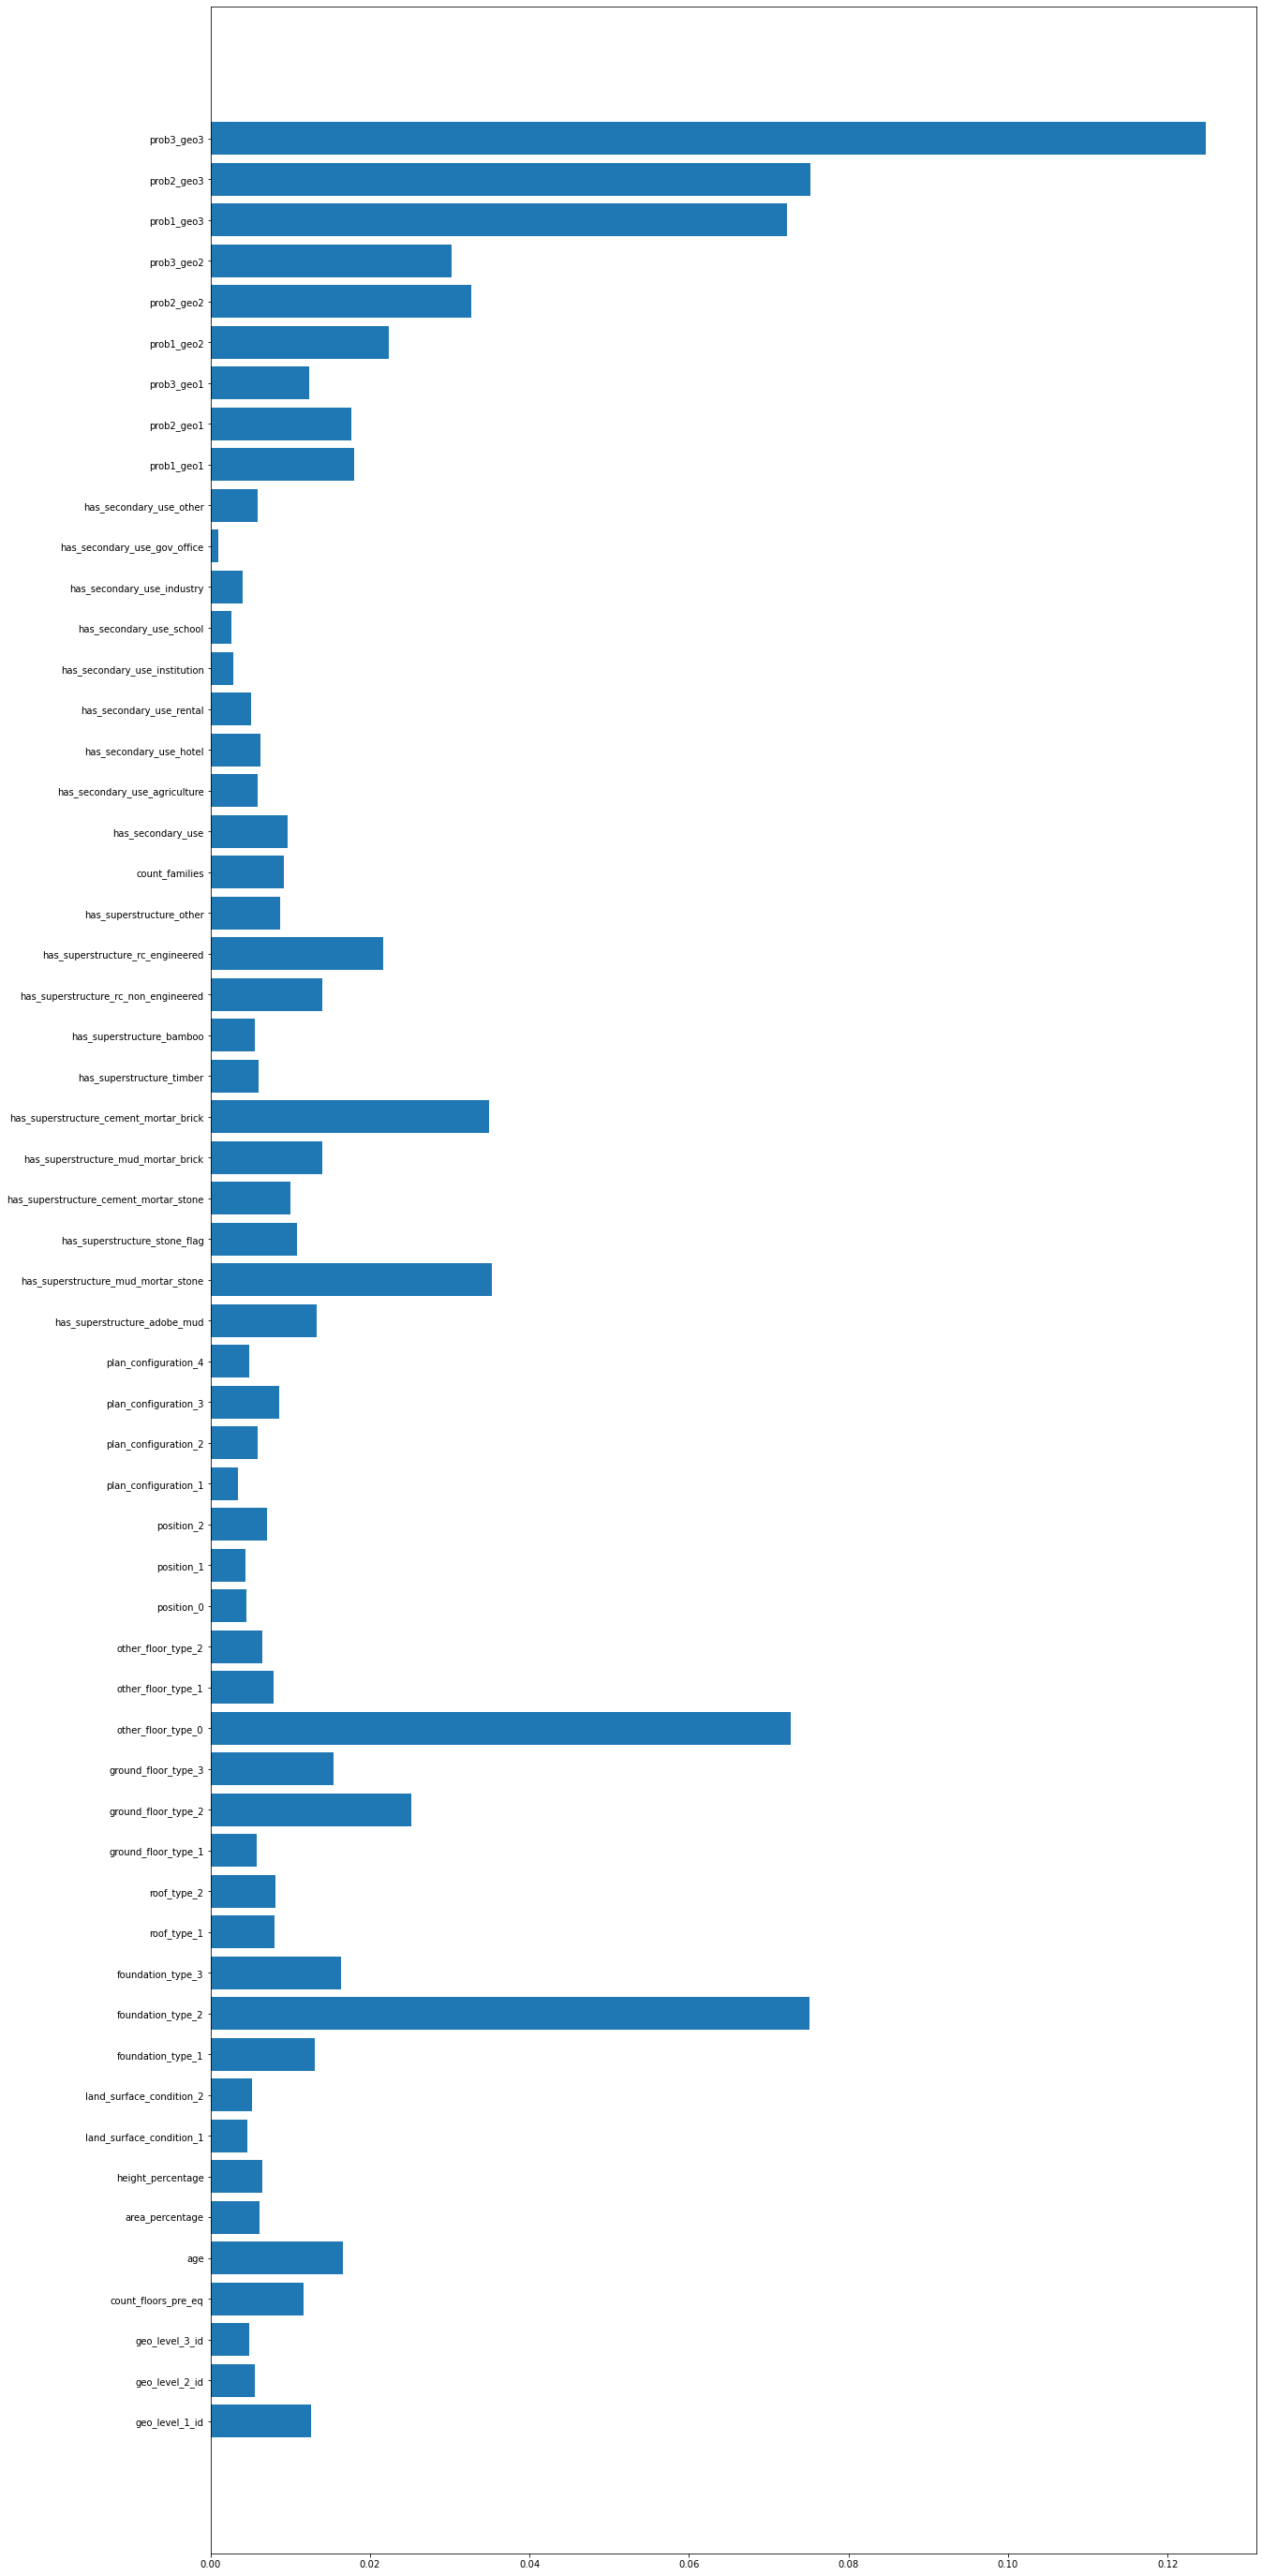

In [403]:
plt.figure(figsize=(20,50))
plt.barh(X.columns, xgb_cl.feature_importances_)


predigo el df_test y creo el file contra el format csv

In [404]:
pred_xgboost_final = xgb_cl.predict(df_test_encoding)


In [405]:
pred_xgboost_final

array([3, 2, 3, ..., 2, 2, 1], dtype=int64)

In [406]:
submission_format = pd.read_csv('submission_format.csv', index_col='building_id')
my_submission = pd.DataFrame(data=pred_xgboost_final,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [407]:
my_submission.head()

,damage_grade
building_id,
300051,3
99355,2
890251,3
745817,1
421793,3


In [408]:
fecha = datetime.datetime.now(pytz.timezone("Etc/GMT+3"))
my_submission.to_csv('_training-result.csv',index= True)